# Data Augmentation

In [1]:
import sys
sys.path.append('..')

## Load Data

In [2]:
import wfdb

def read_record(path, sampto=None):
    record = wfdb.rdrecord(path, sampto=sampto)
    annotation = wfdb.rdann(path, 'atr', sampto=sampto)
    trigger = trigger_points(annotation)
    return record, trigger

def read_records(directory, names, sampto=None):
    records, triggers = [], []
    for name in names:
        path = "/".join([directory, name])
        record, trigger = read_record(path, sampto)
        records.append(record)
        triggers.append(trigger)
    return records, triggers

In [3]:
import numpy as np
from raccoon.utils.annotationutils import trigger_points

# Clean ECG Signals
signal_dir = "../data/mitdb"
names = np.array([
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109"
])
sampto = 10000

clean_records, triggers = read_records(signal_dir, names, sampto)
clean_records, triggers = np.array(clean_records), np.array(triggers)

# Noise template
noise_path = '../data/noises/em'
noise_template = wfdb.rdrecord(noise_path)

## Add Noise

In [4]:
from raccoon.utils.noiseutils import apply_noise_db

noisy_records = [
    apply_noise_db(clean_record, noise_template, 6)
    for clean_record in clean_records]

noisy_records = np.array(noisy_records)

## Create Detectors

In [5]:
from raccoon.detectors import XiangDetector

# Two identically configured detectors

clean_detector = XiangDetector(
    name='clean_detector', batch_size=32, window_size=40, detection_size=20,
    aux_ratio=5, epochs=3)

noisy_detector = XiangDetector(
    name='noisy_detector', batch_size=32, window_size=40, detection_size=20,
    aux_ratio=5, epochs=3)

Using TensorFlow backend.


## Train and Test

In [6]:
from contextlib import redirect_stdout
from io import StringIO
from sklearn.model_selection import LeaveOneOut, KFold
from raccoon.utils.evaluationutils import triggers_metrics

# cv = KFold(n_splits=2)
cv = LeaveOneOut()

clean_metrics, noisy_metrics = [], []

for step_id, (train_indexes, test_indexes) in enumerate(cv.split(names), start=1):
    print("Step {}/{}".format(step_id, cv.get_n_splits(names)))
    
    clean_train_records = clean_records[train_indexes]
    noisy_train_records = noisy_records[train_indexes]
    train_triggers = triggers[train_indexes]
    test_records = noisy_records[test_indexes]
    test_triggers = triggers[test_indexes]
    
    clean_detector.reset()
    noisy_detector.reset()
    
    with redirect_stdout(StringIO()):
        clean_detector.train(clean_train_records, train_triggers)
        noisy_detector.train(noisy_train_records, train_triggers)
    
    clean_triggers = clean_detector.detect(test_records)
    noisy_triggers = noisy_detector.detect(test_records)
    
    clean_metrics.append(triggers_metrics(test_triggers, clean_triggers, 5))
    noisy_metrics.append(triggers_metrics(test_triggers, noisy_triggers, 5))

Step 1/10
Step 2/10
Step 3/10
Step 4/10
Step 5/10
Step 6/10
Step 7/10
Step 8/10
Step 9/10
Step 10/10


## Outlier Removal

In [7]:
clean_metrics2 = [v for i,v in enumerate(clean_metrics) if i != 8]

In [8]:
noisy_metrics2 = [v for i,v in enumerate(noisy_metrics) if i != 8]

## Calculate Statistics

In [9]:
from raccoon.utils.evaluationutils import sensitivity, ppv, f1

labels = ['Se', 'PPV', 'F1']

clean_stats = np.array([
    [sensitivity(tp, fn) for tp, tn, fp, fn in clean_metrics2],
    [ppv(tp, fp) for tp, tn, fp, fn in clean_metrics2],
    [f1(tp, fp, fn) for tp, tn, fp, fn in clean_metrics2]])

noisy_stats = np.array([
    [sensitivity(tp, fn) for tp, tn, fp, fn in noisy_metrics2],
    [ppv(tp, fp) for tp, tn, fp, fn in noisy_metrics2],
    [f1(tp, fp, fn) for tp, tn, fp, fn in noisy_metrics2]])

clean_means = np.nanmean(clean_stats, axis=1)
noisy_means = np.nanmean(noisy_stats, axis=1)

clean_stds = np.nanstd(clean_stats, axis=1)
noisy_stds = np.nanstd(noisy_stats, axis=1)

In [10]:
from scipy.stats import ttest_ind

for label, clean, noisy in zip(labels, clean_stats, noisy_stats):
    print("{}: {}".format(label, ttest_ind(clean, noisy)))

Se: Ttest_indResult(statistic=0.8505632607971843, pvalue=0.4075610564202222)
PPV: Ttest_indResult(statistic=-0.4018294907957742, pvalue=0.6931260357740083)
F1: Ttest_indResult(statistic=0.30083776906558696, pvalue=0.7674123046249378)


## Plot

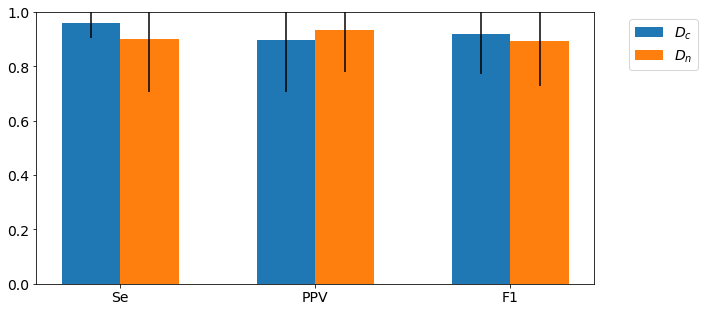

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

bar_width = 0.3
index = np.arange(3) # Se, PPV, F1

ax.bar(index, clean_means, bar_width, yerr=clean_stds, label=r'$D_c$')

ax.bar(index+bar_width, noisy_means, bar_width, yerr=noisy_stds, label=r'$D_n$')

ax.set_xticks(index + 0.5*bar_width)
ax.set_xticklabels(('Se', 'PPV', 'F1'))
ax.set_ylim(0, 1)

ax.legend(bbox_to_anchor=(1.05, 1))

plt.show()

In [13]:
save=True

if save:
    fig.savefig(
        '../../msc-thesis/thesis/images/data_augmentation.png',
        bbox_inches = 'tight',
        pad_inches = 0.1)